In [2]:
FRAME_SIZE = 150
HOP_RATIO = 0.1
N_FFT = 1024

In [3]:
import importlib
import modules.AudioProcessor
importlib.reload(modules.AudioProcessor)
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([2664, 7200])
(2664,)
(2664,)


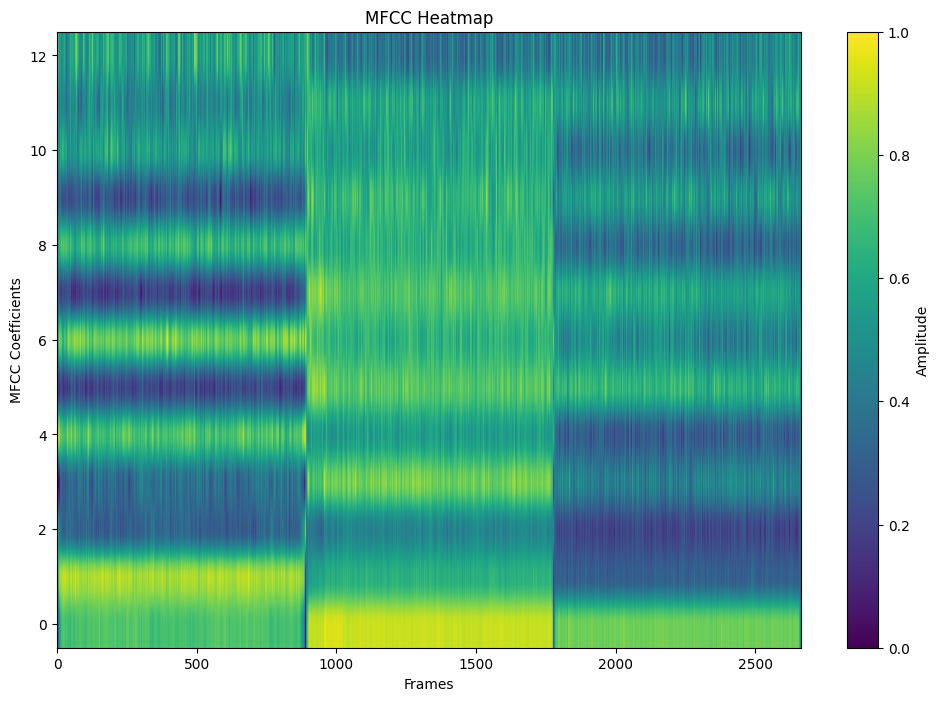

torch.Size([2664, 13])

In [4]:
import importlib
import modules.FeatureExtractor
importlib.reload(modules.FeatureExtractor)
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames)
fe.plot_mfccs()
fe.mfcc_features.shape

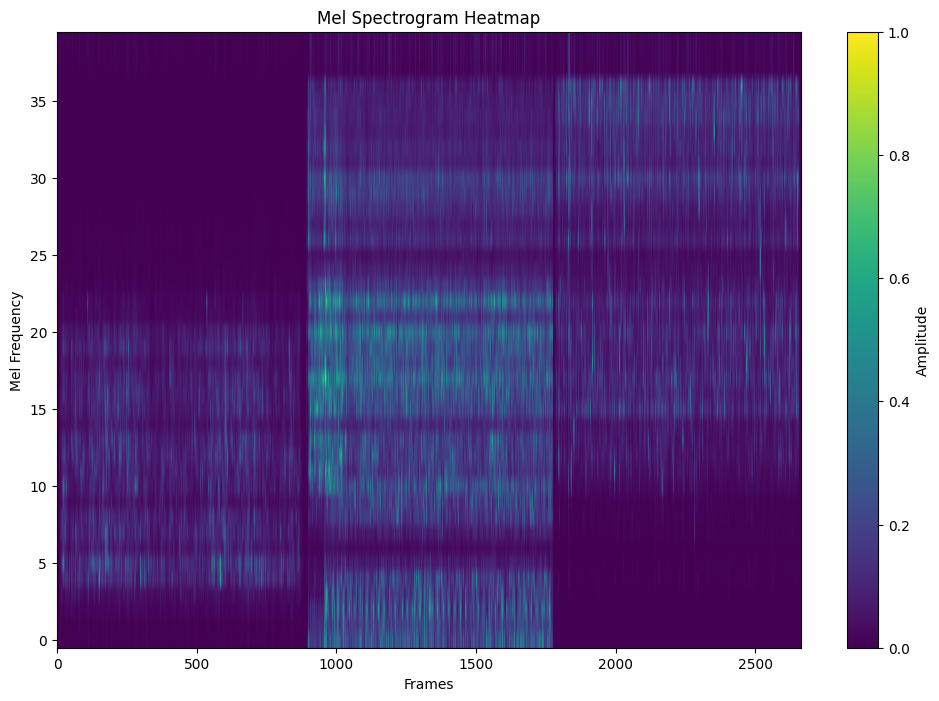

torch.Size([2664, 40])

In [5]:
fe.extract_melspectrogram(ap.frames)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [6]:
import warnings
import importlib
import modules.DatasetHandler
importlib.reload(modules.DatasetHandler)
from modules.DatasetHandler import DatasetHandler

warnings.filterwarnings("ignore")

dh = DatasetHandler(
    class_ids=ap.class_ids,
    timestamps=ap.timestamps, 
    mfccs=fe.mfcc_features, 
    mfsc=fe.melspectrogram_features,
    output_dir='output/no_pca' 
)
dh.generate_csv('all_features.csv')

In [7]:
important_mfccs = [i for i in range(13)]
important_mfsc = []
dh.save_selected_features(important_mfccs, important_mfsc, "mfccs_only.csv")
time_series_tensor = dh.generate_time_series('mfccs_only.csv', 'mfccs')

important_mfccs = []
important_mfsc = [i for i in range(40)]
dh.save_selected_features(important_mfccs, important_mfsc, "melspec_only.csv")
time_series_tensor = dh.generate_time_series('melspec_only.csv', 'melspec')

important_mfccs = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc = [i for i in range(14)] + [i for i in range(16, 35)]
dh.save_selected_features(important_mfccs, important_mfsc, "combined.csv")
time_series_tensor = dh.generate_time_series('combined.csv', 'combined')


In [8]:
import modules.ART2Clusterer
importlib.reload(modules.ART2Clusterer)
from modules.ART2Clusterer import ART2Clusterer
import pandas as pd

def cluster_dataset(i, filename, n_features, plot_name, vigilance, pca=False):
    magenta = "\033[35m"
    green = "\033[32m"
    end = "\033[0m"
    print(f"{magenta}Clustering time series {i}{end} - {filename} features")
    df = pd.read_csv(f'output/{"" if pca else "no_"}pca/time_series_{i}/{filename}_{i}.csv')
    clusterer = ART2Clusterer(
        vigilance=vigilance, 
        n_features=n_features,
        time_series_index=i,
    )
    for index, row in df.iterrows():
        clusterer.fit_clusters(row)

    clusterer.write_to_csv()
    conf_matrix, acc = clusterer.calc_accuracy()
    print(f"{green}Accuracy:{end} {acc}")
    print(f"{green}Confusion Matrix:{end}\n{conf_matrix}")
    clusterer.plot_truth_vs_time(plot_name)

Clustering time series 0 - mfccs features
Accuracy: 0.9876126126126126
Confusion Matrix:
[[341   0   0]
 [  0 258   0]
 [  0   1 278]]


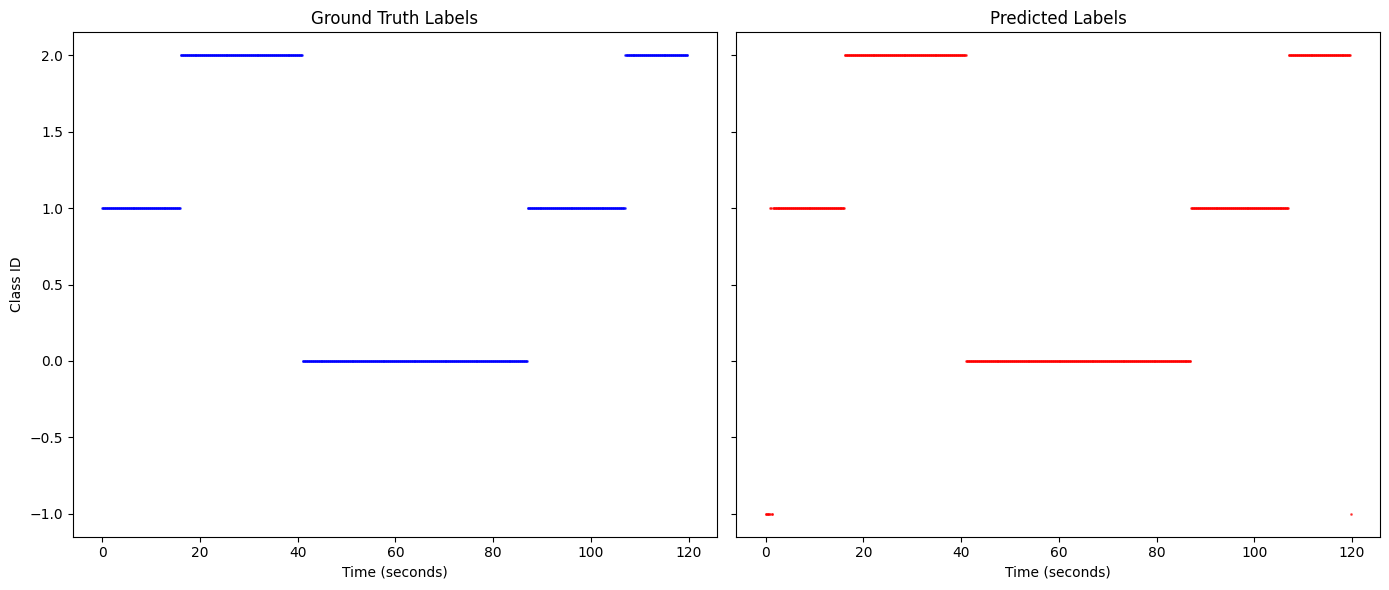

Clustering time series 0 - melspec features
Accuracy: 0.8096846846846847
Confusion Matrix:
[[392   0   0]
 [ 19 121   0]
 [ 80   3 206]]


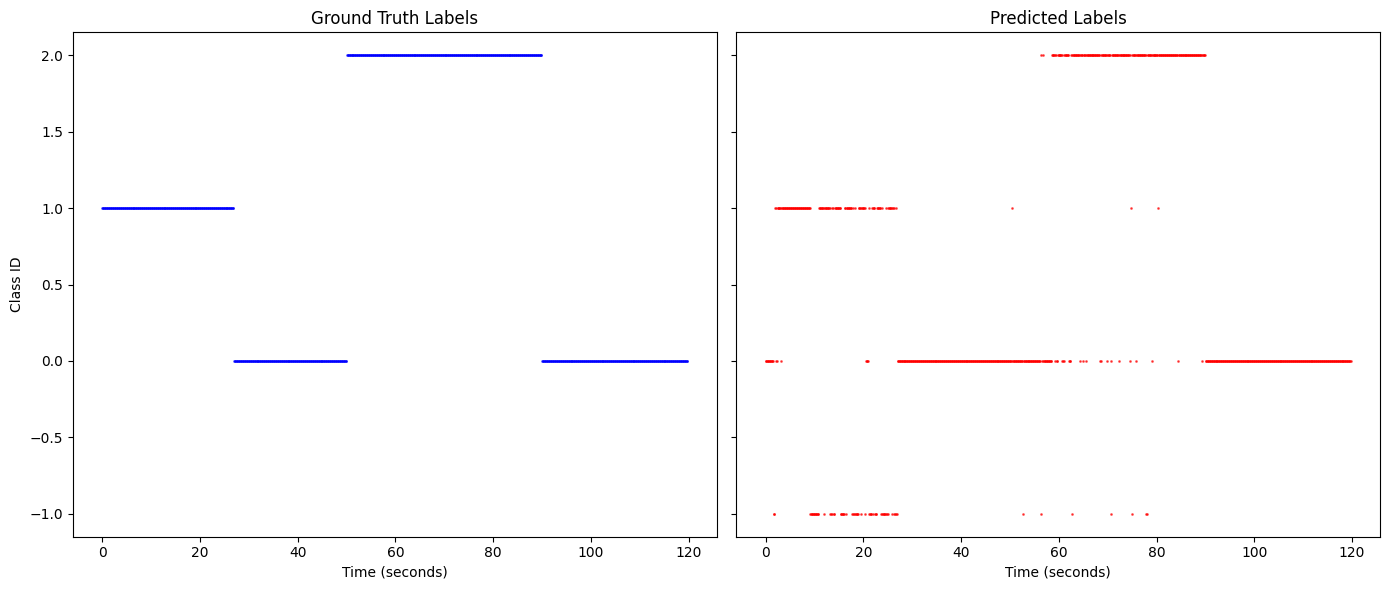

Clustering time series 0 - combined features
Accuracy: 0.9887387387387387
Confusion Matrix:
[[330   0   1]
 [  0 288   1]
 [  0   0 260]]


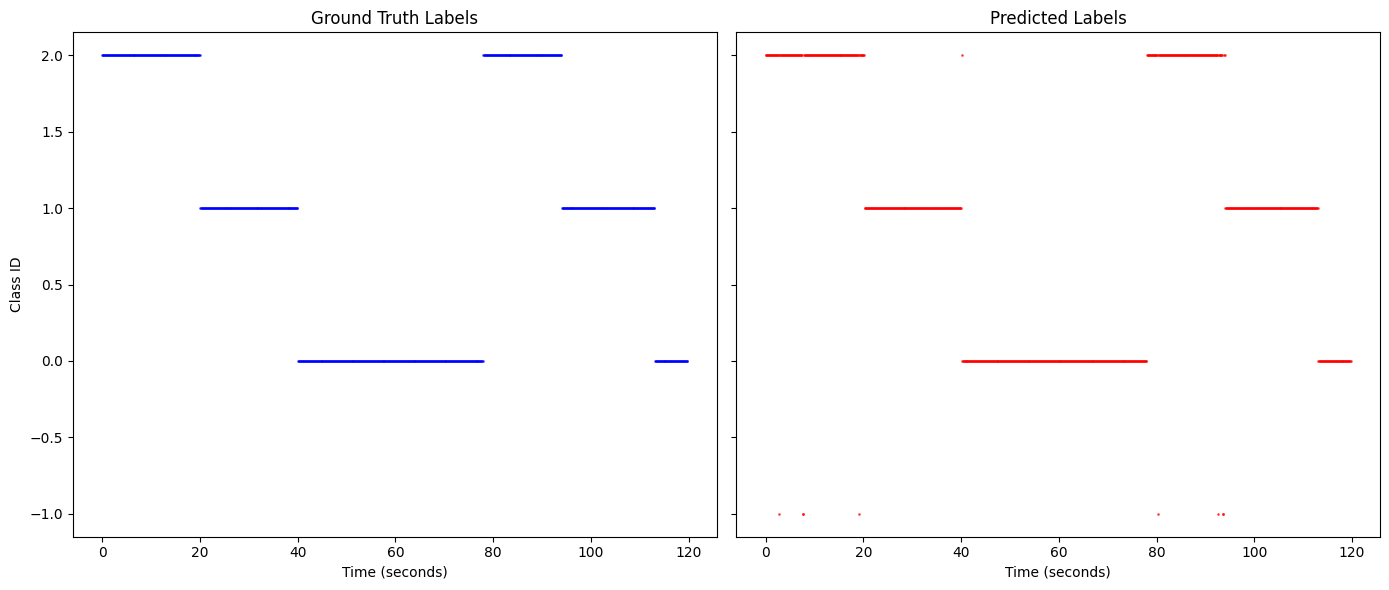

--------------------------------------------------------------------------------
Clustering time series 1 - mfccs features
Accuracy: 0.9887387387387387
Confusion Matrix:
[[300   0   0]
 [  0 289   0]
 [  0   0 289]]


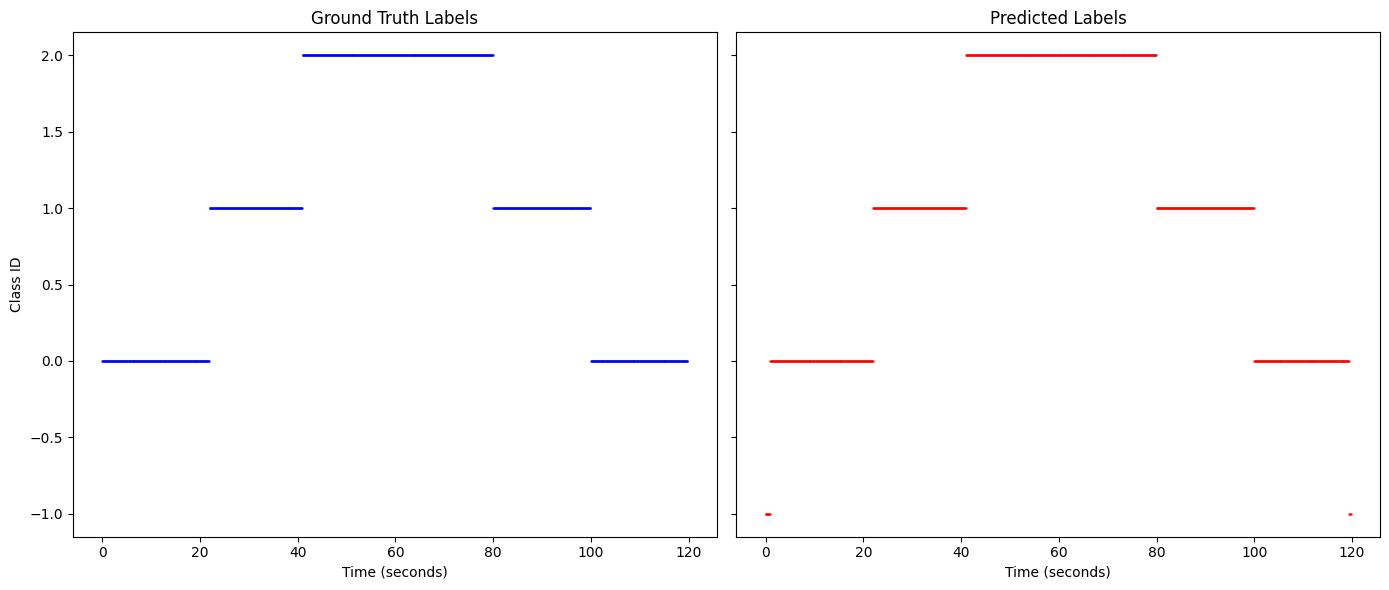

Clustering time series 1 - melspec features
Accuracy: 0.6891891891891891
Confusion Matrix:
[[310   0   0]
 [  0 257   0]
 [255   0  45]]


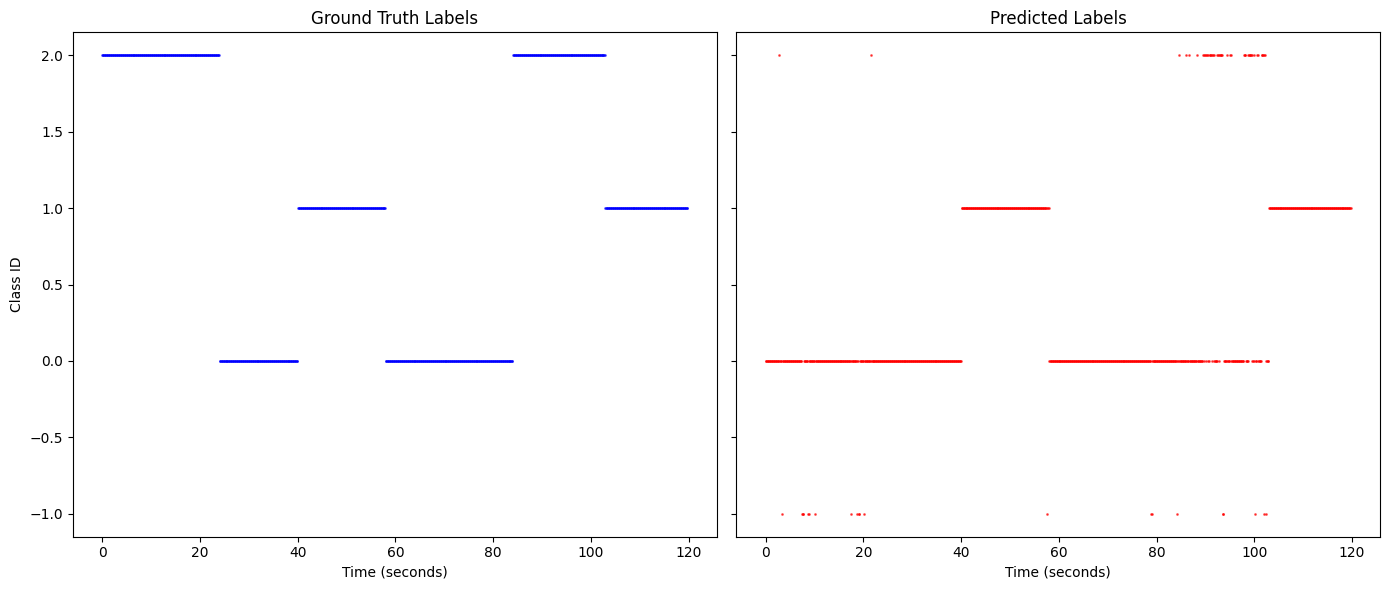

Clustering time series 1 - combined features
Accuracy: 0.9842342342342343
Confusion Matrix:
[[166   0   2]
 [  0 397   2]
 [  0   0 311]]


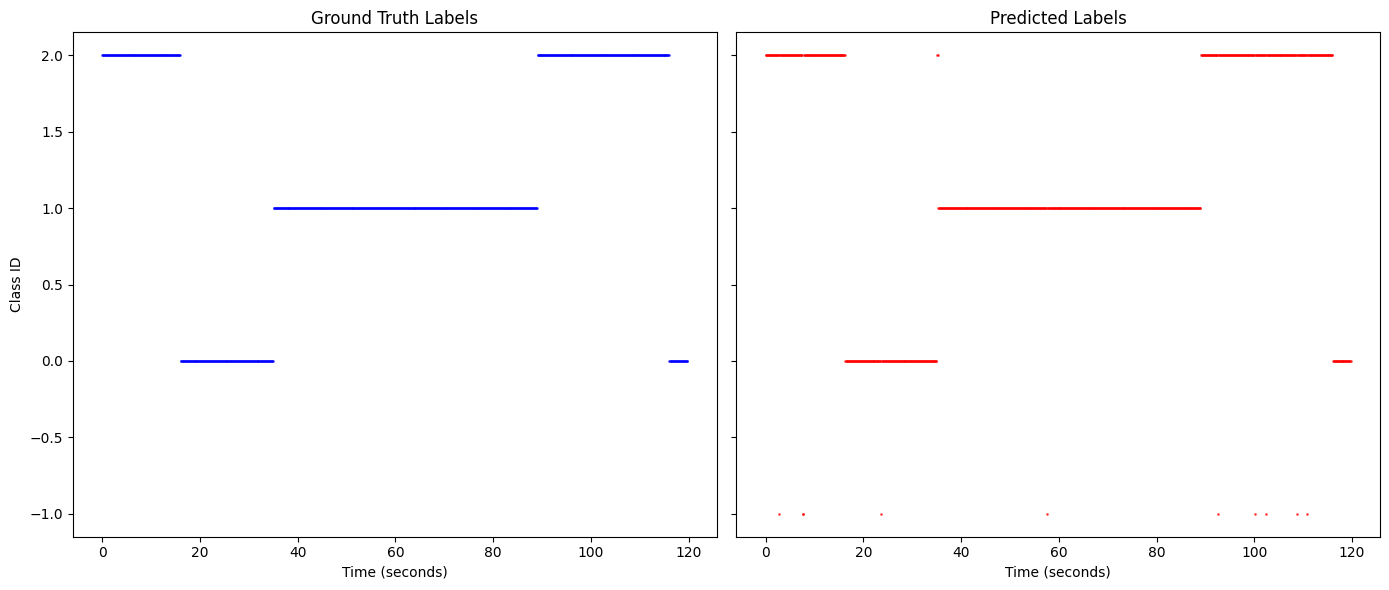

--------------------------------------------------------------------------------
Clustering time series 2 - mfccs features
Accuracy: 1.0
Confusion Matrix:
[[268   0   0]
 [  0 287   0]
 [  0   0 333]]


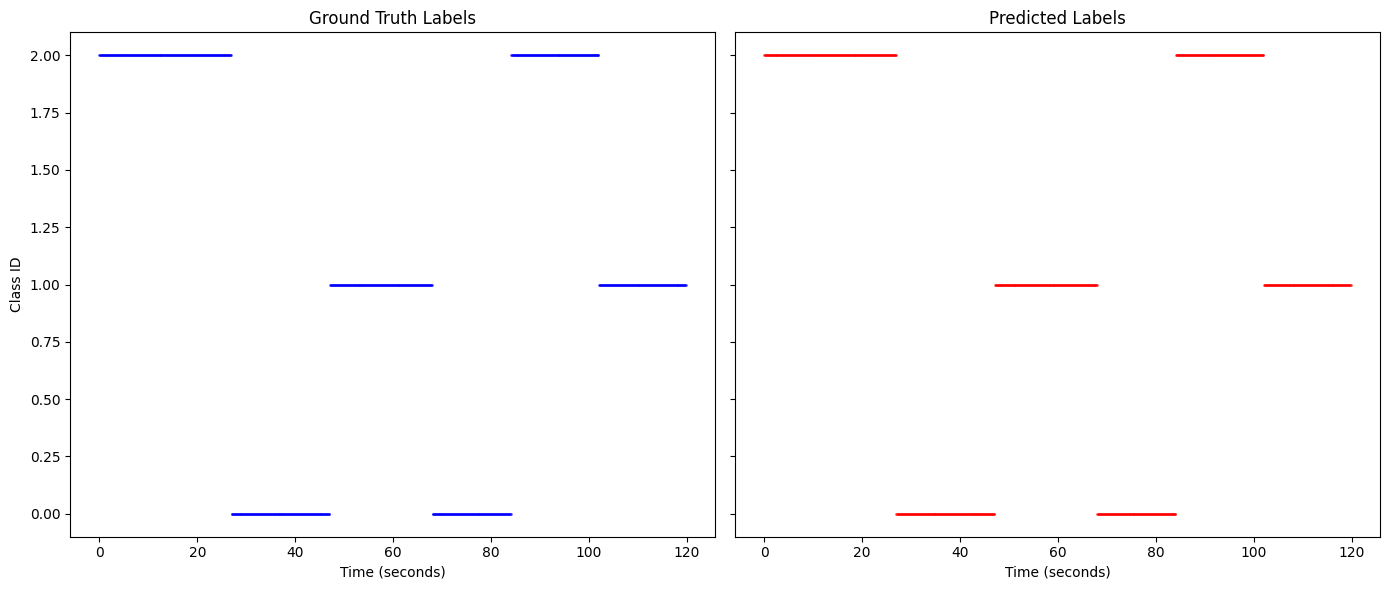

Clustering time series 2 - melspec features
Accuracy: 0.8806306306306306
Confusion Matrix:
[[363   0   0]
 [  0 295   0]
 [ 63   0 124]]


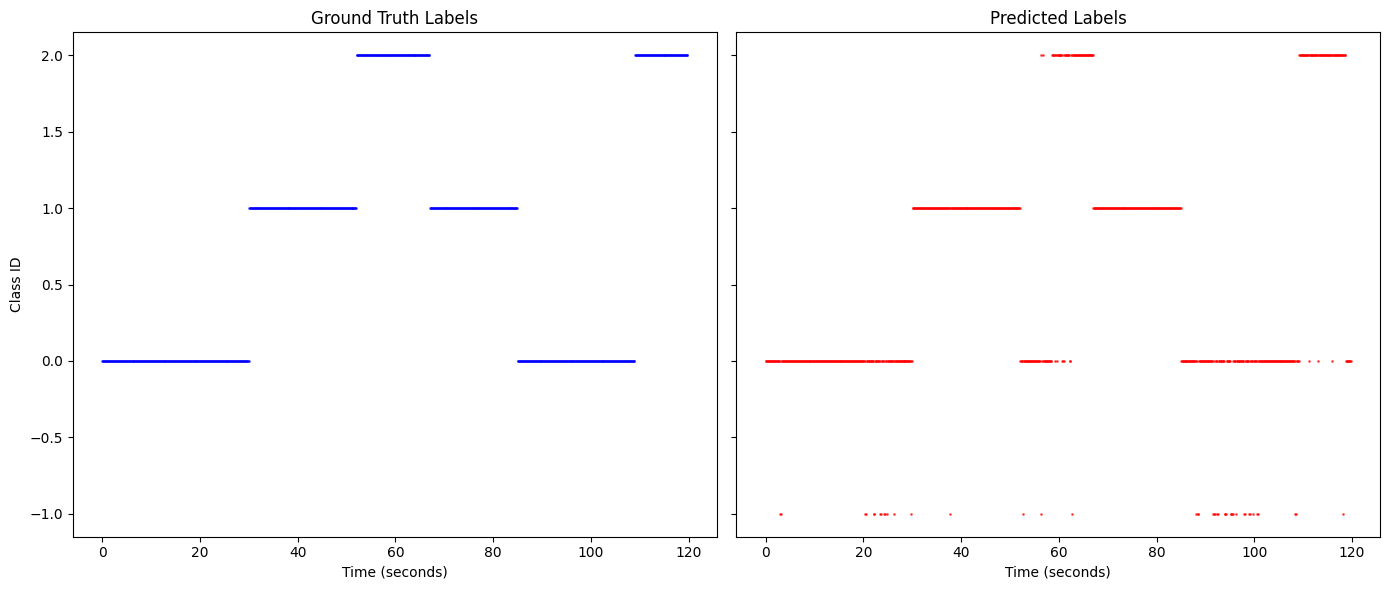

Clustering time series 2 - combined features
Accuracy: 0.865990990990991
Confusion Matrix:
[[332   0   0]
 [ 12 299   0]
 [  1   6 138]]


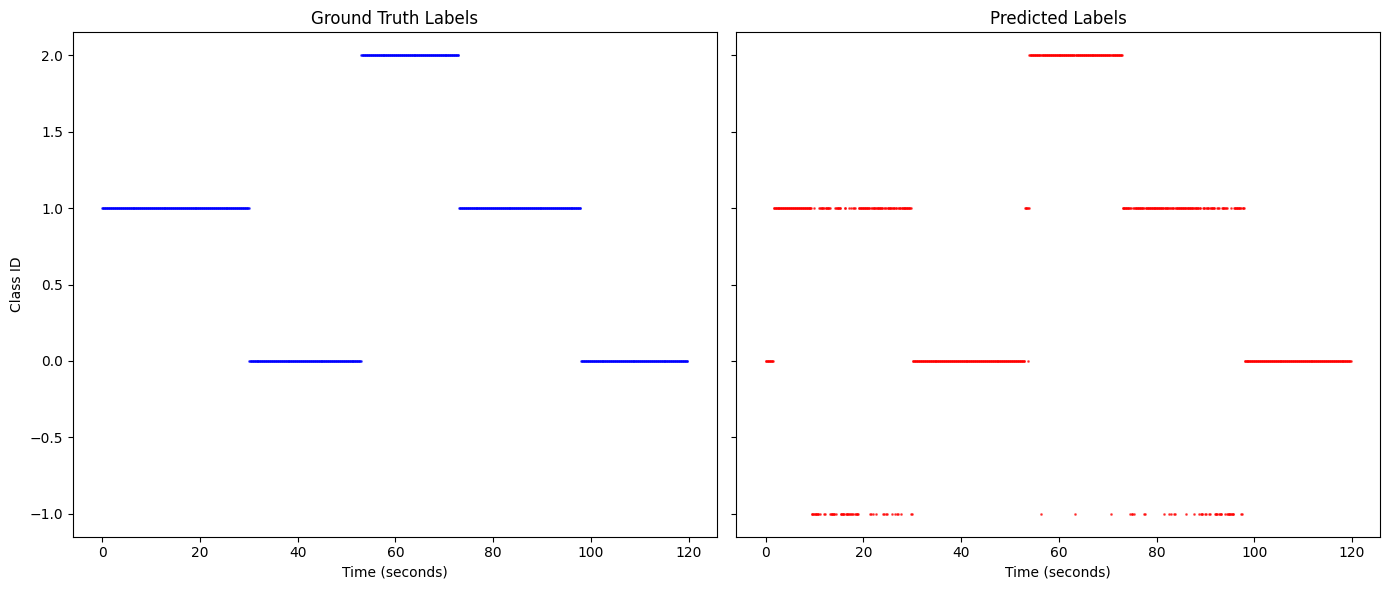

--------------------------------------------------------------------------------
Clustering time series 3 - mfccs features
Accuracy: 0.990990990990991
Confusion Matrix:
[[275   0   0]
 [  0 312   0]
 [  0   0 293]]


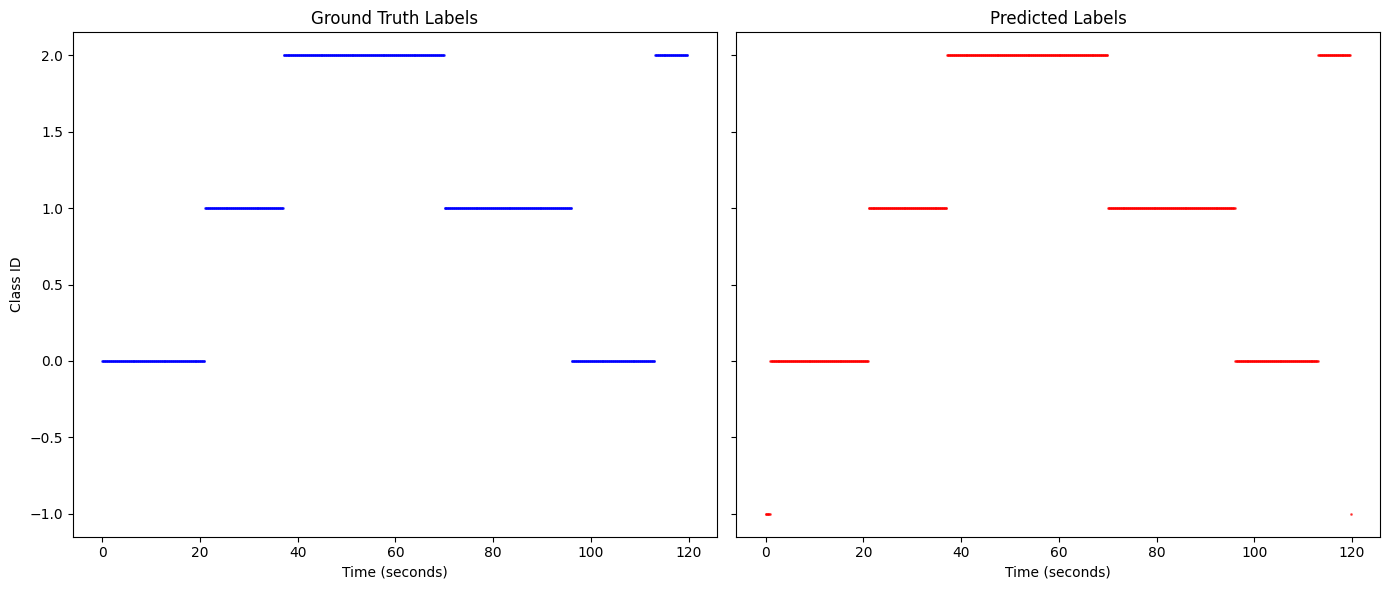

Clustering time series 3 - melspec features
Accuracy: 0.8592342342342343
Confusion Matrix:
[[310   0   0]
 [  2 262   0]
 [108   2 191]]


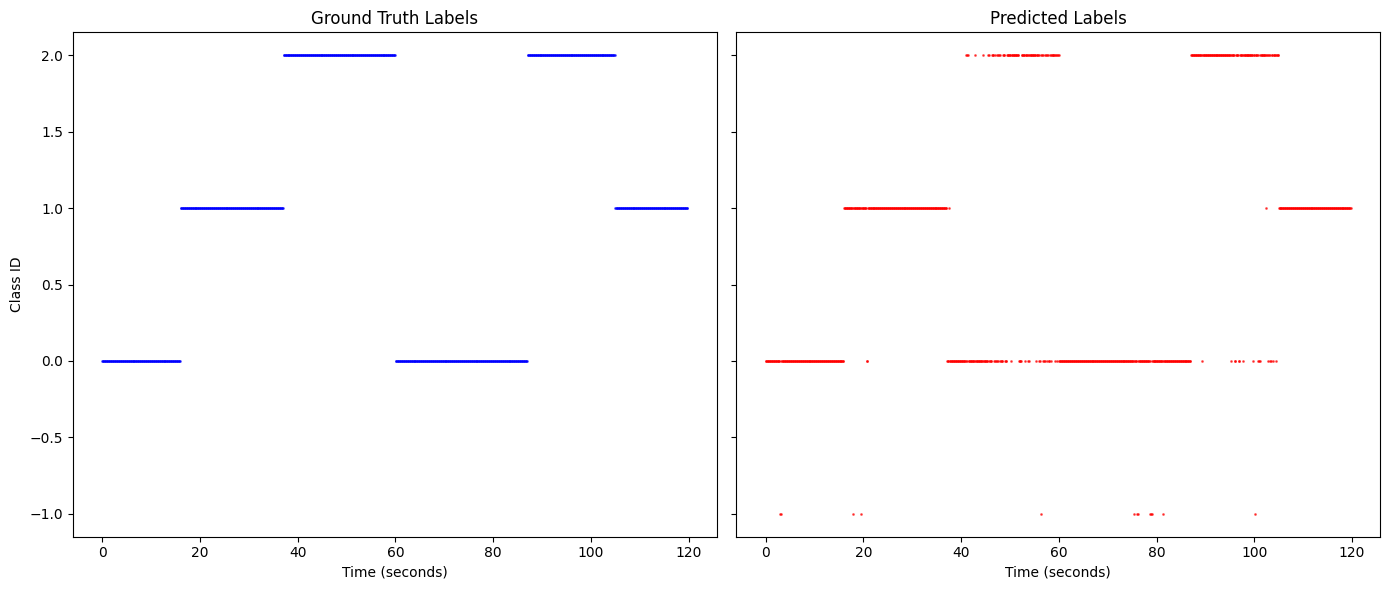

Clustering time series 3 - combined features
Accuracy: 0.9932432432432432
Confusion Matrix:
[[274   0   0]
 [  0 340   0]
 [  0   0 268]]


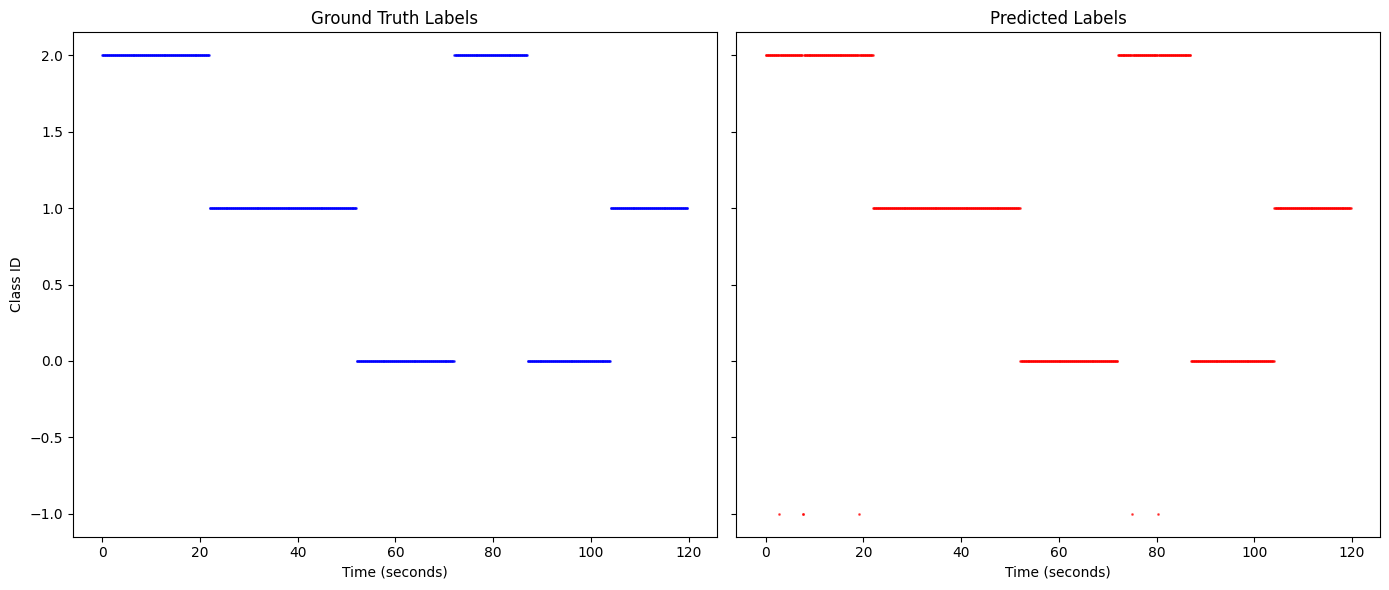

--------------------------------------------------------------------------------
Clustering time series 4 - mfccs features
Accuracy: 0.9988738738738738
Confusion Matrix:
[[303   0   0]
 [  0 282   0]
 [  0   0 302]]


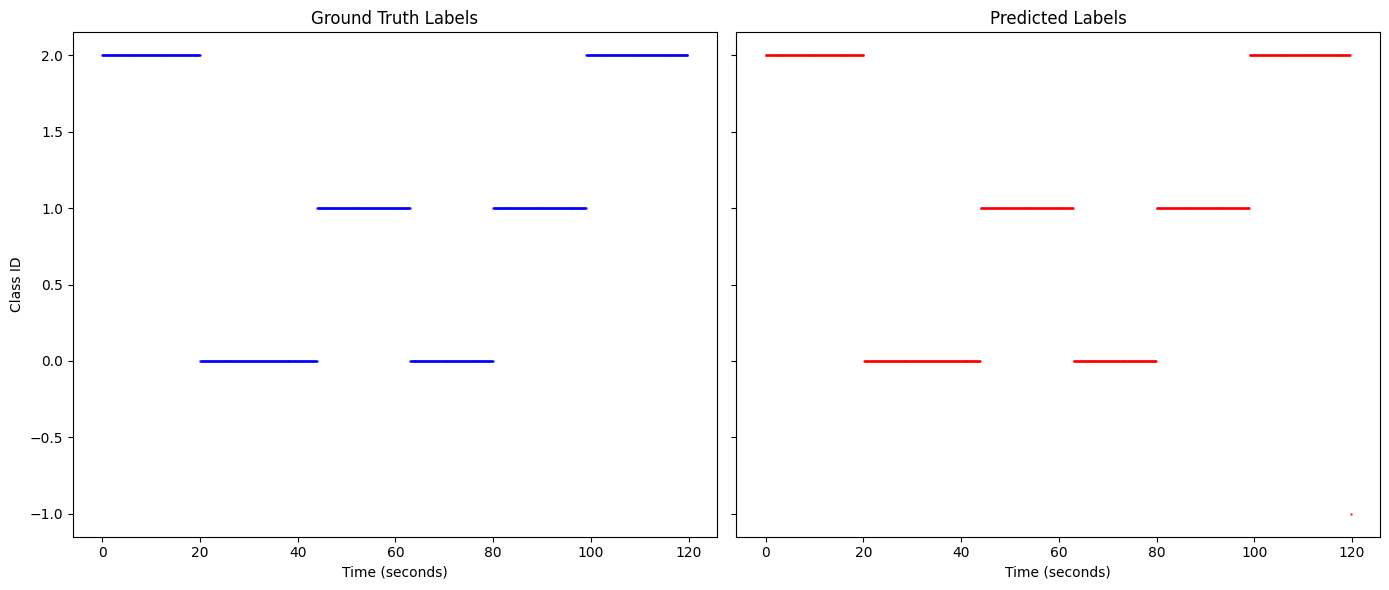

Clustering time series 4 - melspec features
Accuracy: 0.7331081081081081
Confusion Matrix:
[[390   0   0]
 [  0 256   1]
 [205   4   5]]


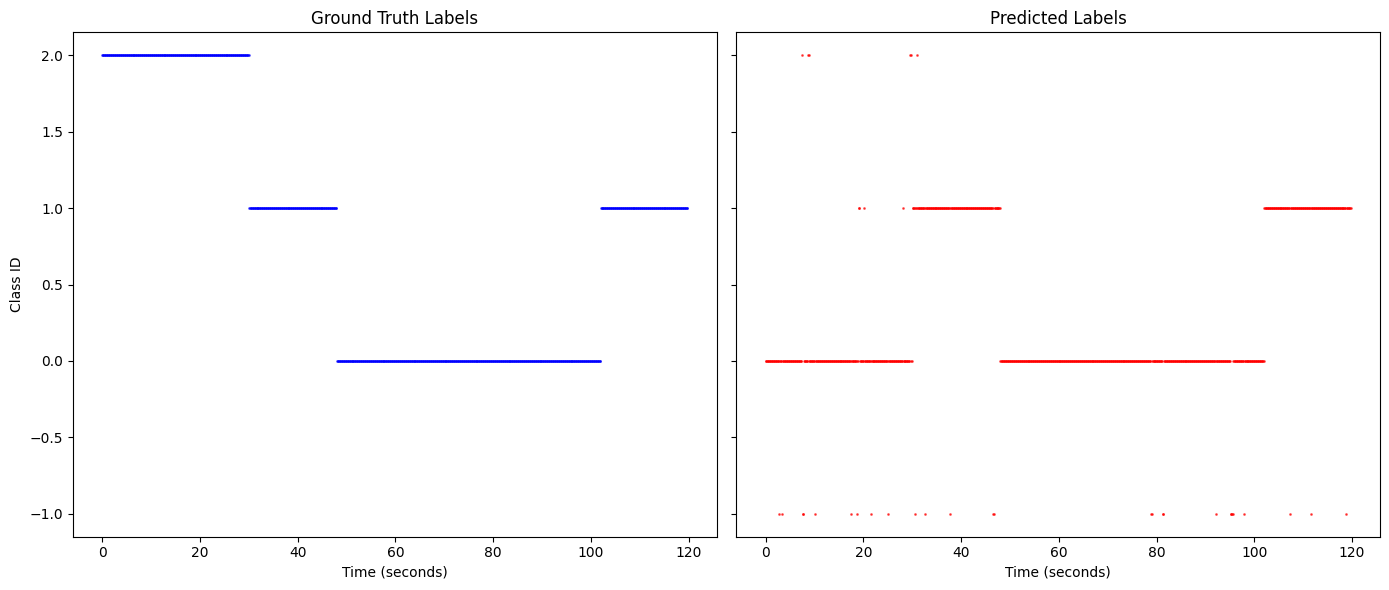

Clustering time series 4 - combined features
Accuracy: 0.9977477477477478
Confusion Matrix:
[[414   0   0]
 [  0 259   0]
 [  0   0 213]]


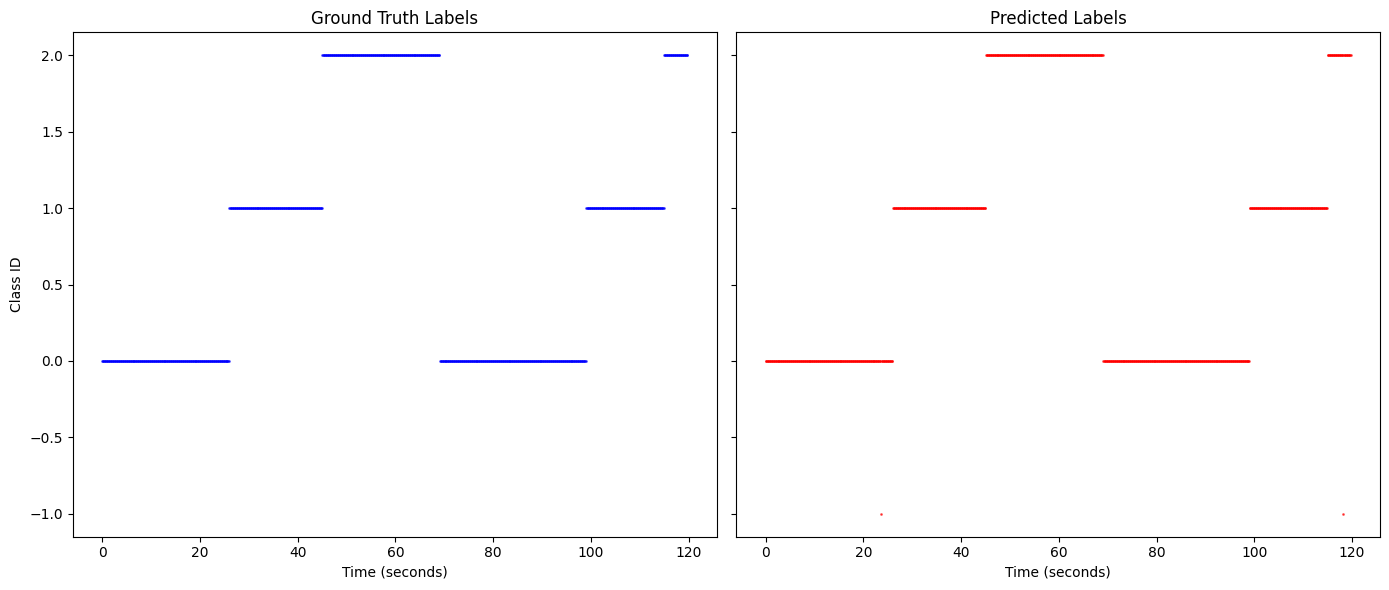

--------------------------------------------------------------------------------


In [9]:
MFCC_VIGILANCE = 0.5
MELSPEC_VIGILANCE = 0.95
COMBINED_VIGILANCE = 1.4

n_features = len(important_mfccs) + len(important_mfsc)
for i in range(5):
    cluster_dataset(i, 'mfccs', 13, 'MFCCs Only Ground Truth vs Predicted Labels', MFCC_VIGILANCE)
    cluster_dataset(i, 'melspec', 40, 'MFSCs Only Ground Truth vs Predicted Labels', MELSPEC_VIGILANCE)
    cluster_dataset(i, 'combined', n_features, 'Combined Ground Truth vs Predicted Labels', COMBINED_VIGILANCE)
    print('-'*80)

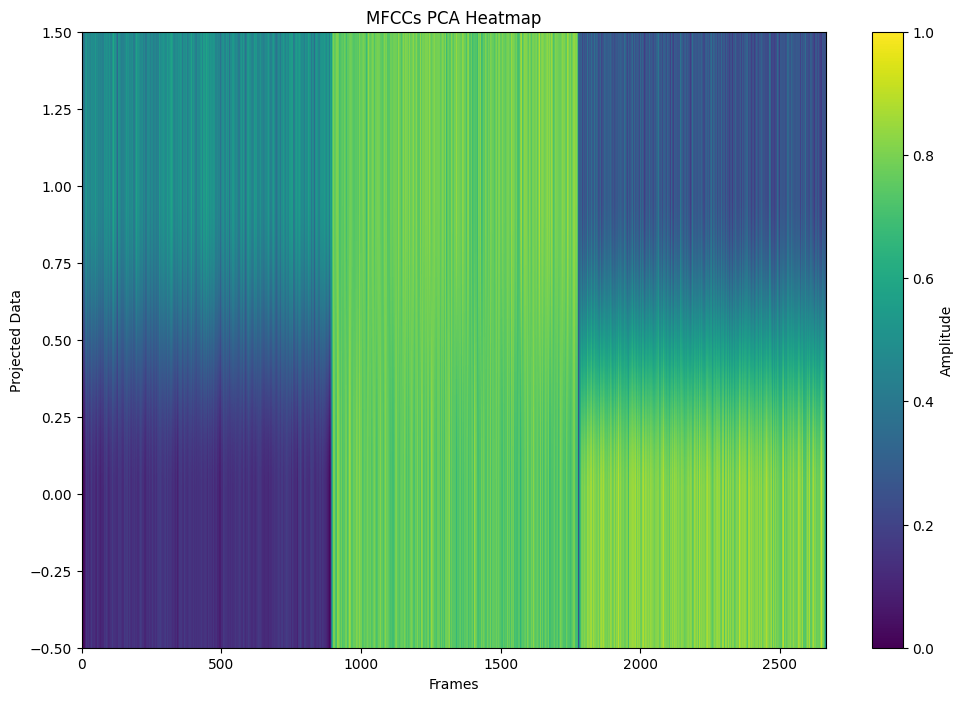

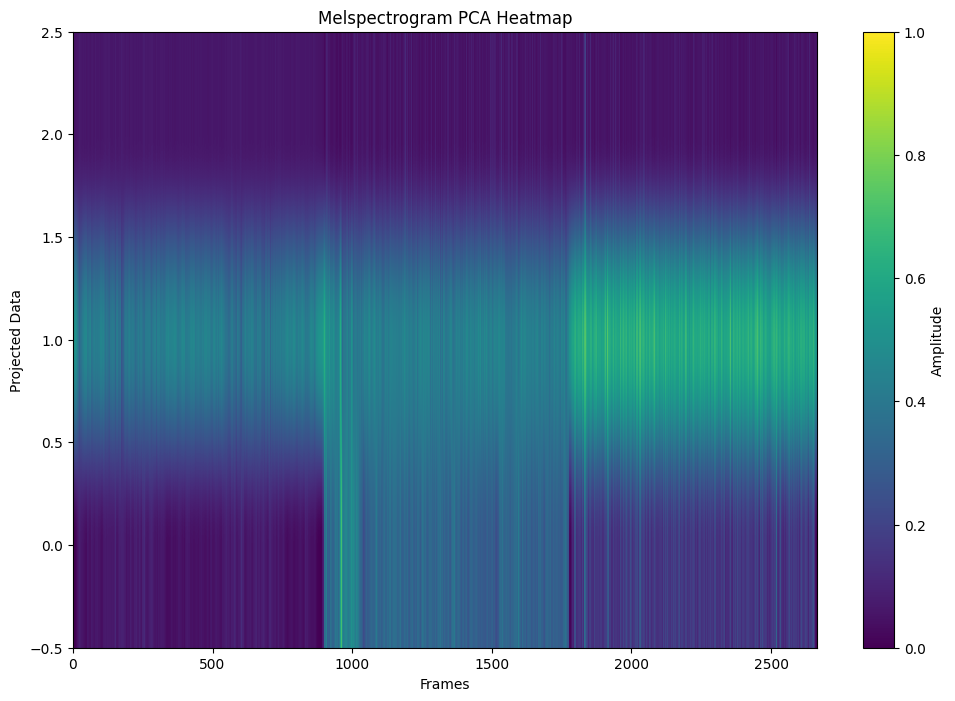

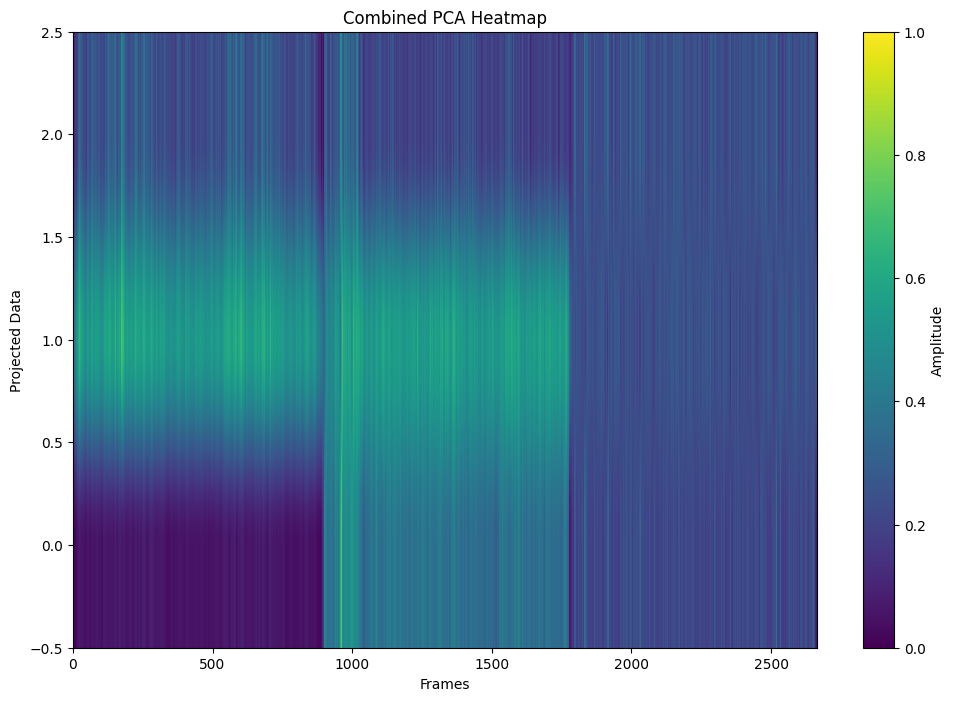

In [19]:
import modules.PCA
importlib.reload(modules.PCA)
from modules.PCA import PCA

mfccs_pca = PCA('output/no_pca/mfccs_only.csv', 0.6)
mfccs_pca.plot_projected_data("MFCCs PCA Heatmap")

mfsc_pca = PCA('output/no_pca/melspec_only.csv',  0.6)
mfsc_pca.plot_projected_data("Melspectrogram PCA Heatmap")

combined_pca = PCA('output/no_pca/combined.csv',  0.6)
combined_pca.plot_projected_data("Combined PCA Heatmap")
dh.set_output('output/pca')

dh.features = mfccs_pca.projected_data
dh.generate_csv("mfccs_only.csv", pca=True)
time_series_tensor = dh.generate_time_series('mfccs_only.csv', 'mfccs')

dh.features = mfsc_pca.projected_data
dh.generate_csv("melspec_only.csv", pca=True)
time_series_tensor = dh.generate_time_series('melspec_only.csv', 'melspec')

dh.features = combined_pca.projected_data
dh.generate_csv("combined.csv", pca=True)
time_series_tensor = dh.generate_time_series('combined.csv', 'combined')

# Optimal Clustering Results for PCA

Clustering time series 0 - mfccs features
Accuracy: 0.6238738738738738
Confusion Matrix:
[[221   0   0]
 [  6   0 328]
 [  0   0 333]]


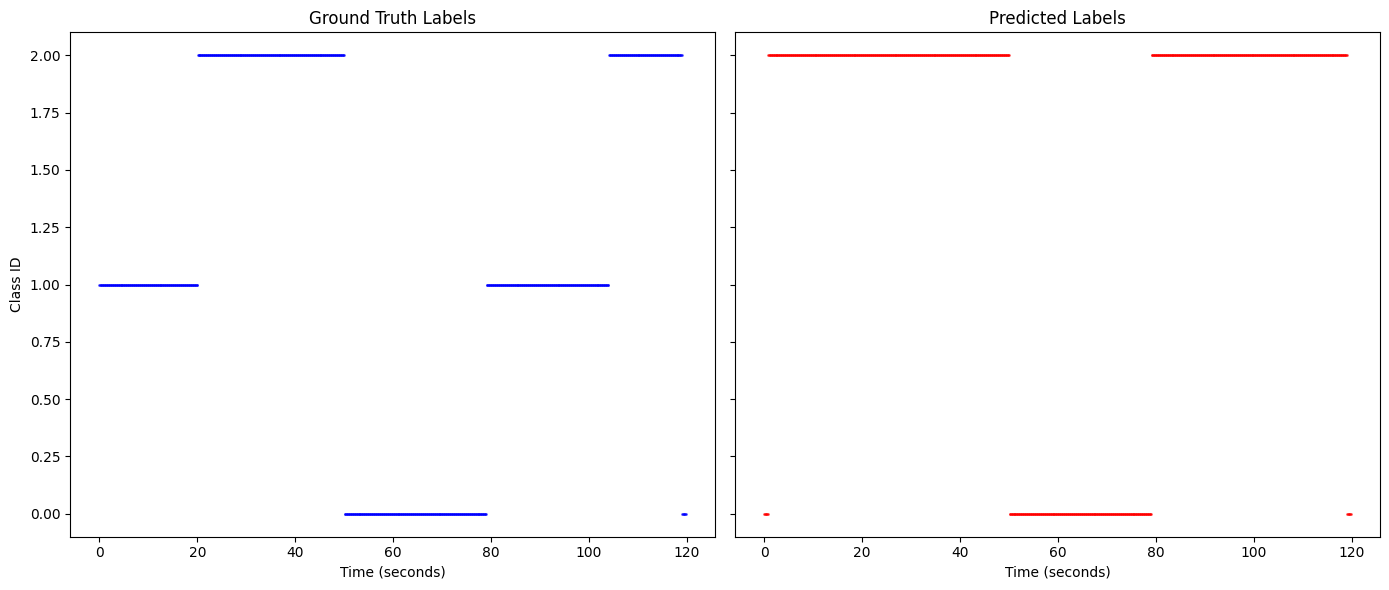

Clustering time series 0 - melspec features
Accuracy: 0.4740990990990991
Confusion Matrix:
[[  0   0 243]
 [  0   0 222]
 [  1   1 421]]


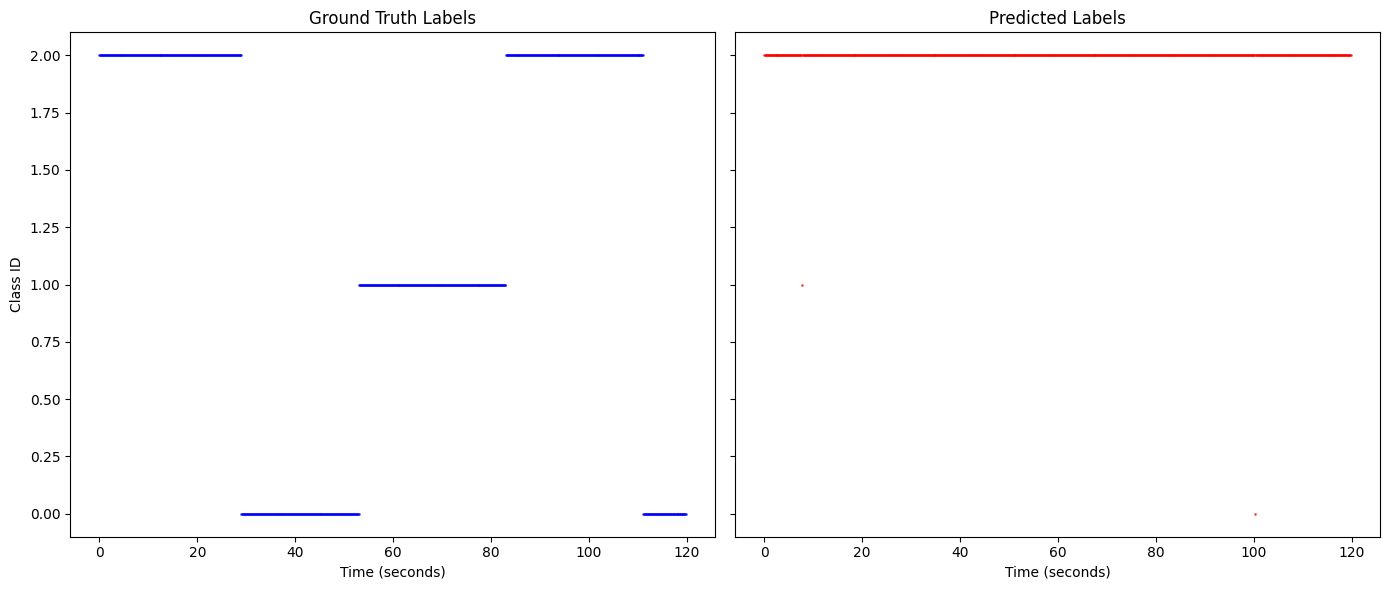

Clustering time series 0 - combined features
Accuracy: 0.7443693693693694
Confusion Matrix:
[[250   0   0]
 [ 18 320   0]
 [196   8  91]]


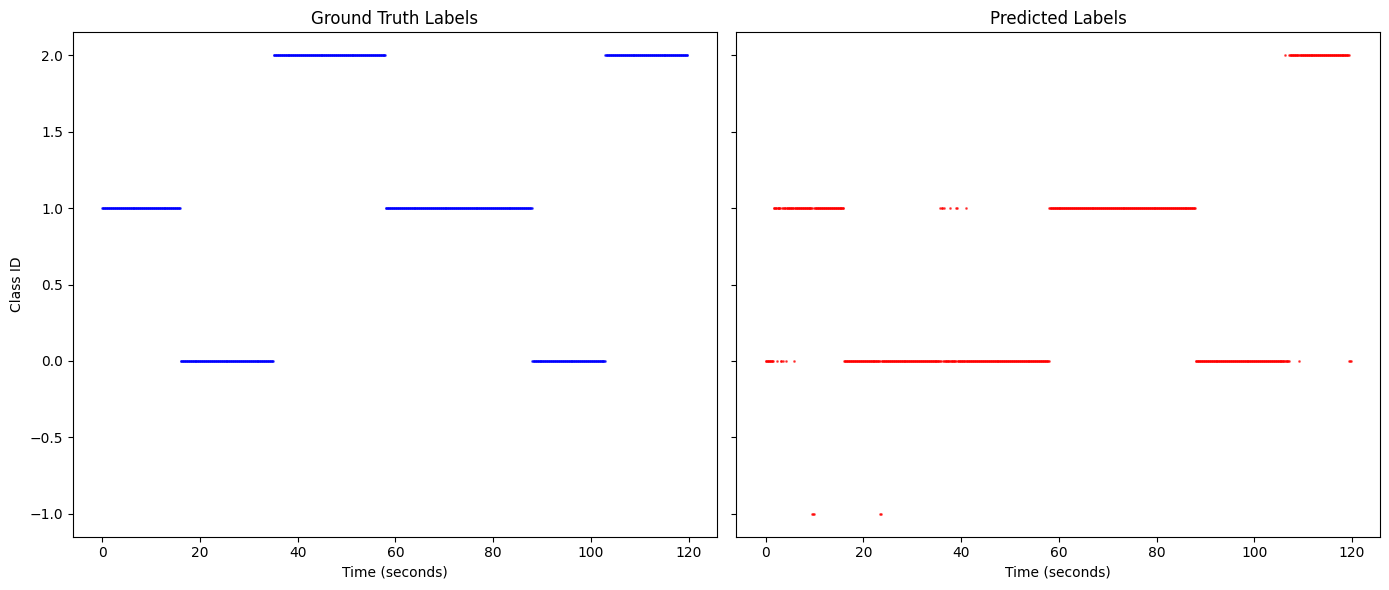

--------------------------------------------------------------------------------
Clustering time series 1 - mfccs features
Accuracy: 0.661036036036036
Confusion Matrix:
[[244   0   0]
 [  6 343   0]
 [  1 294   0]]


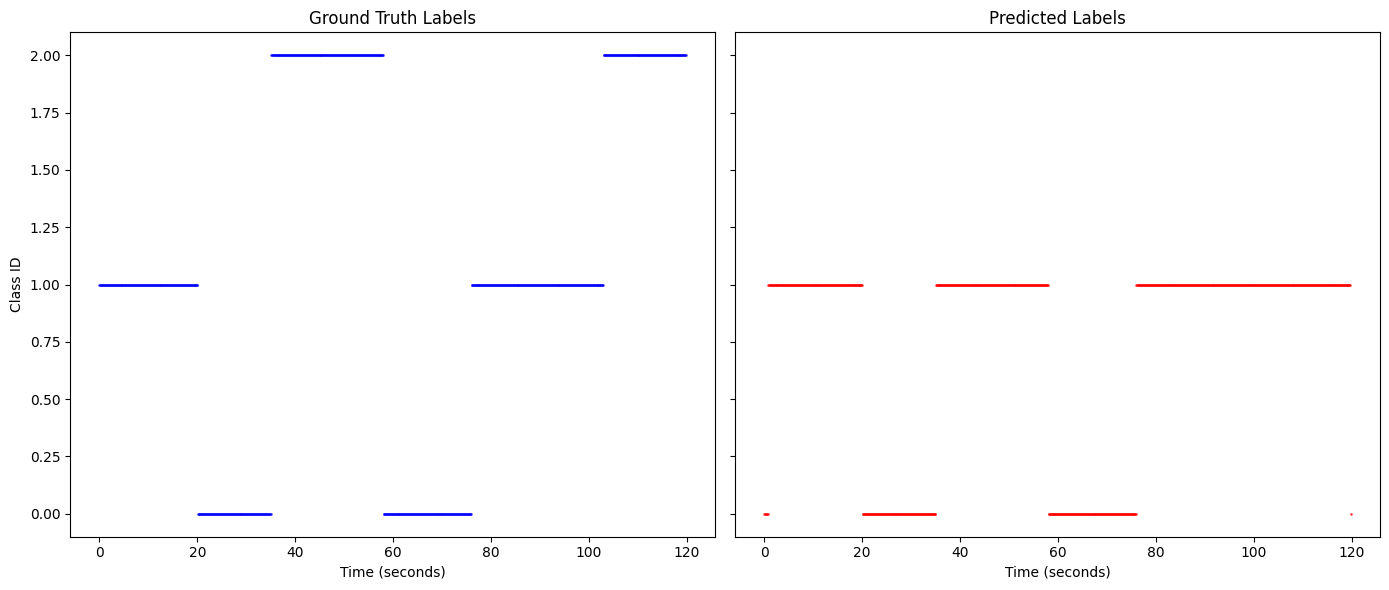

Clustering time series 1 - melspec features
Accuracy: 0.42342342342342343
Confusion Matrix:
[[  0 193   0]
 [  0 376   0]
 [  0 319   0]]


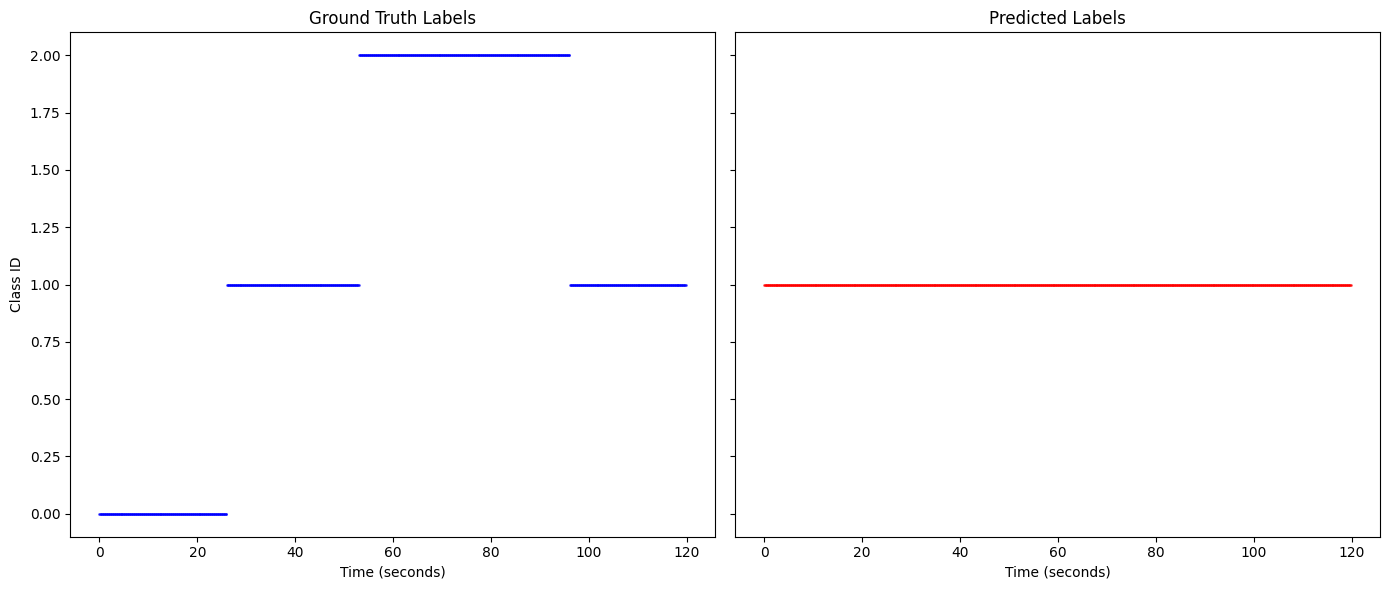

Clustering time series 1 - combined features
Accuracy: 0.6599099099099099
Confusion Matrix:
[[  2 271   0]
 [  0 318   0]
 [  0  30 266]]


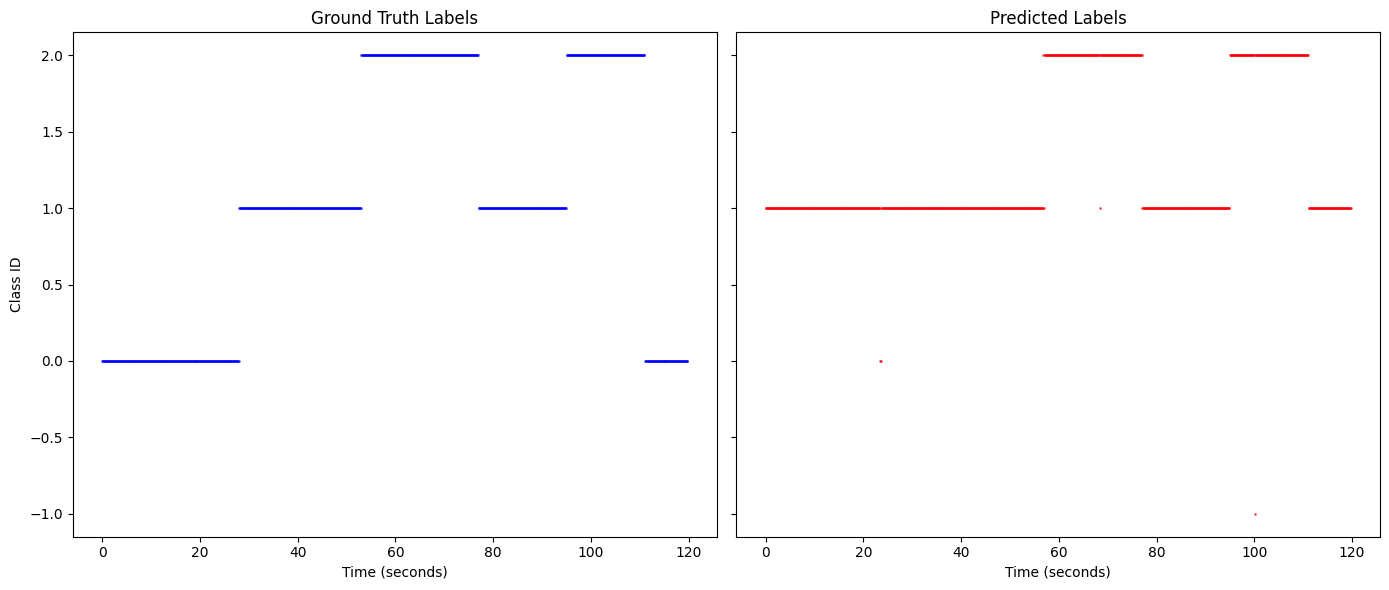

--------------------------------------------------------------------------------
Clustering time series 2 - mfccs features
Accuracy: 0.6835585585585585
Confusion Matrix:
[[244   0   0]
 [  0 363   0]
 [  0 281   0]]


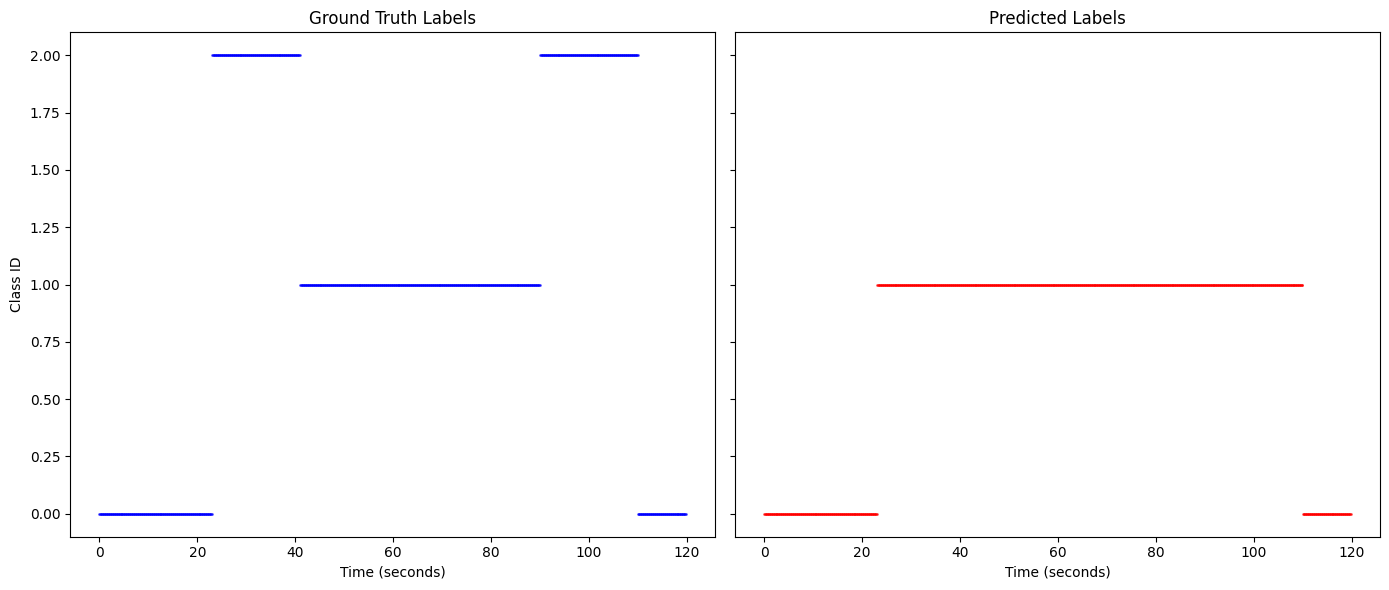

Clustering time series 2 - melspec features
Accuracy: 0.6261261261261262
Confusion Matrix:
[[430   0   0]
 [ 28 126   2]
 [297   5   0]]


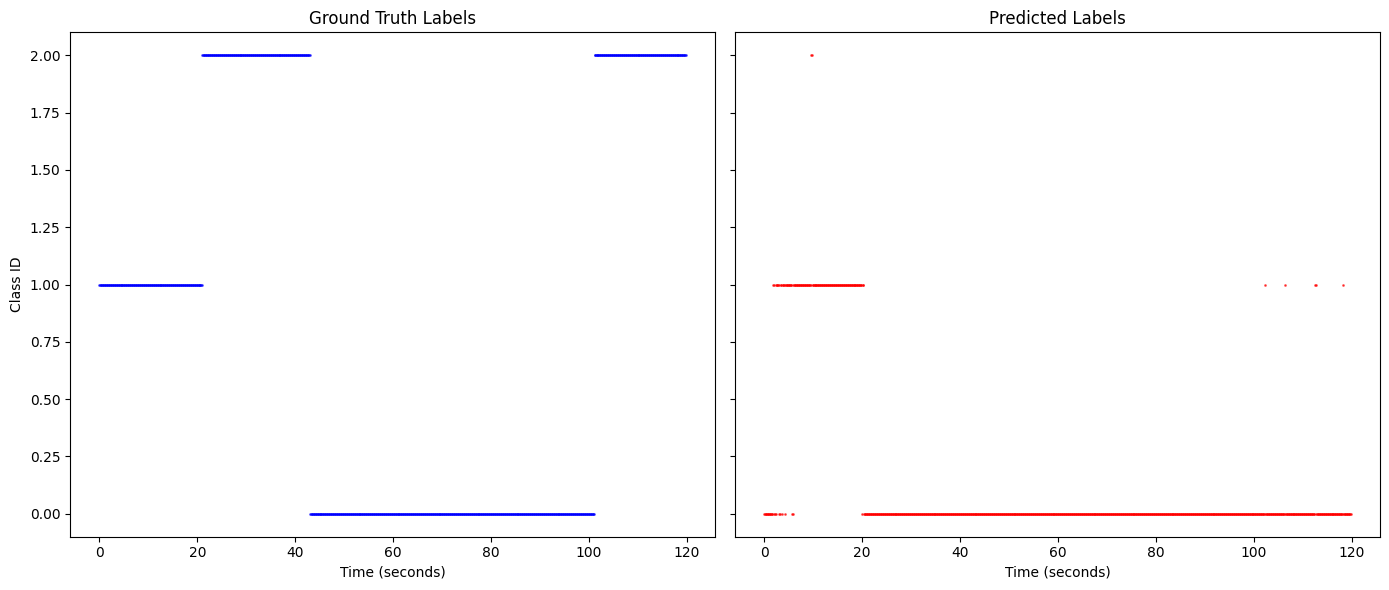

Clustering time series 2 - combined features
Accuracy: 0.7882882882882883
Confusion Matrix:
[[296   0   0]
 [ 31 367   0]
 [153   1  37]]


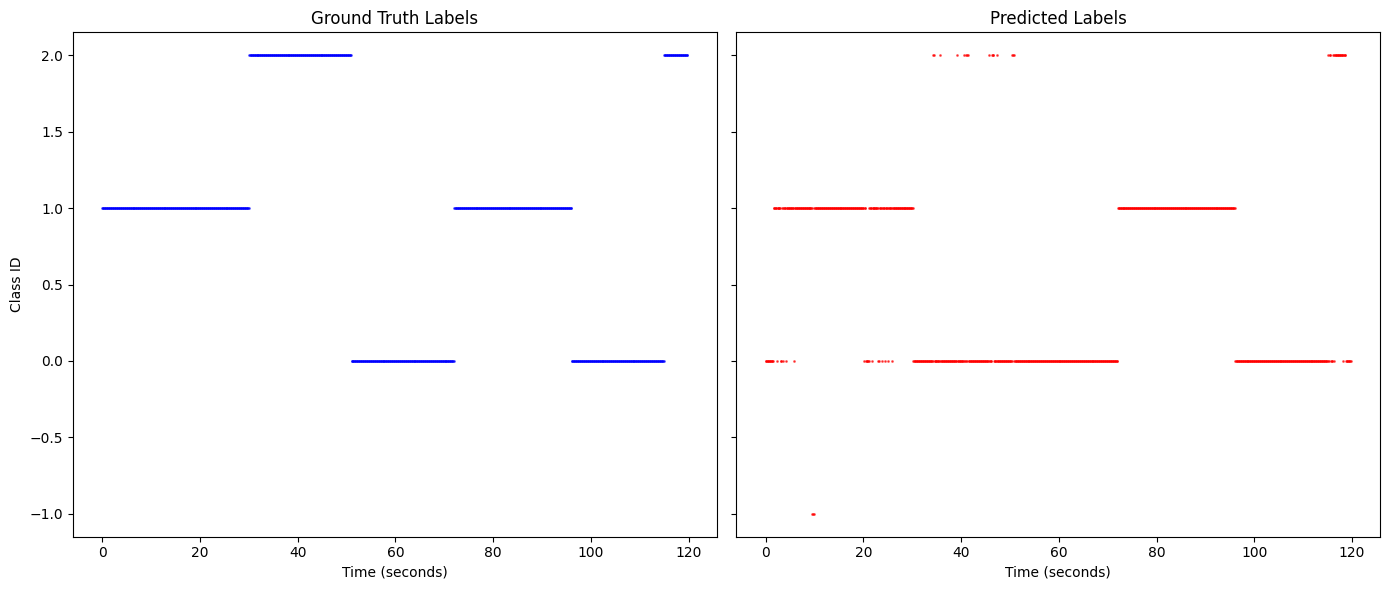

--------------------------------------------------------------------------------
Clustering time series 3 - mfccs features
Accuracy: 0.7240990990990991
Confusion Matrix:
[[341   0   0]
 [  0   0 244]
 [  1   0 302]]


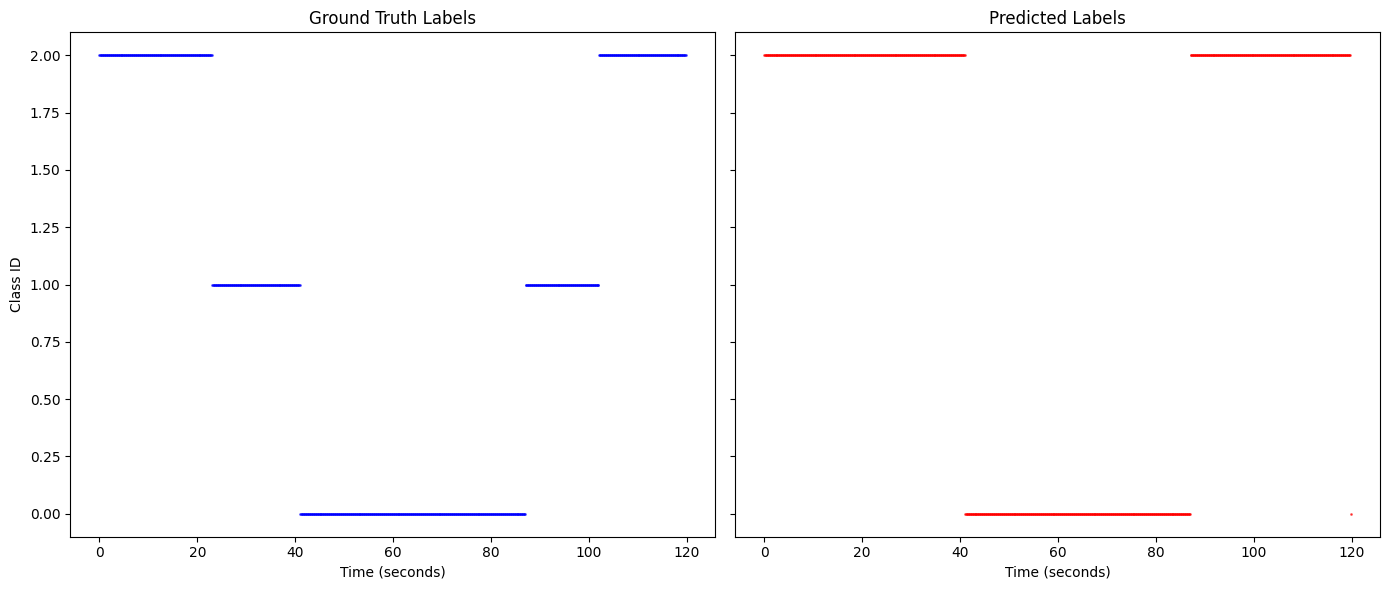

Clustering time series 3 - melspec features
Accuracy: 0.5833333333333334
Confusion Matrix:
[[  0   0 325]
 [  2 184  43]
 [  0   0 334]]


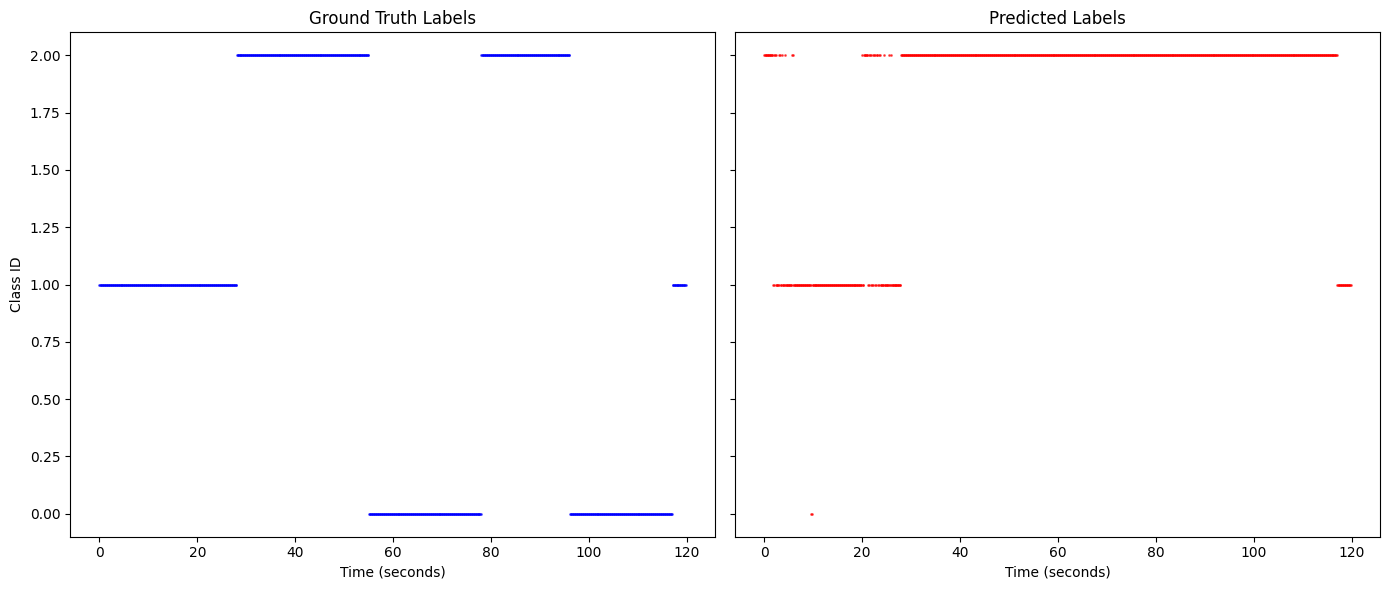

Clustering time series 3 - combined features
Accuracy: 0.581081081081081
Confusion Matrix:
[[286   0   2]
 [281   0  28]
 [  0  59 230]]


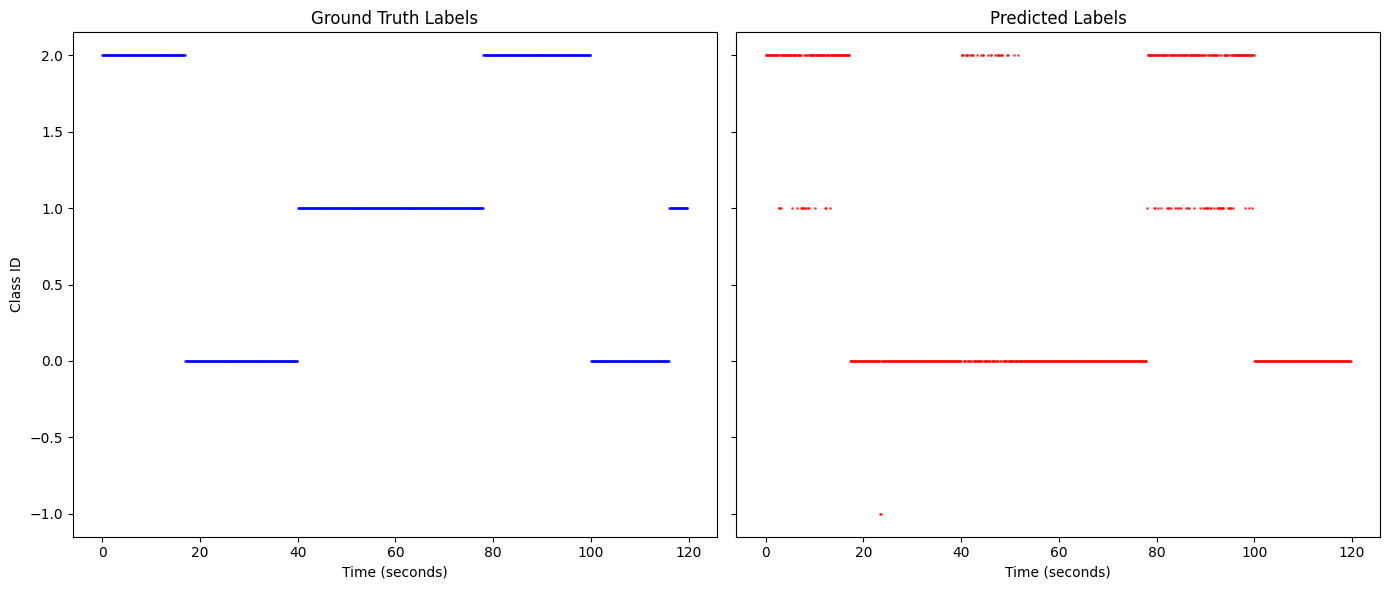

--------------------------------------------------------------------------------
Clustering time series 4 - mfccs features
Accuracy: 0.7759009009009009
Confusion Matrix:
[[333   0   0]
 [  6 356   0]
 [  0 193   0]]


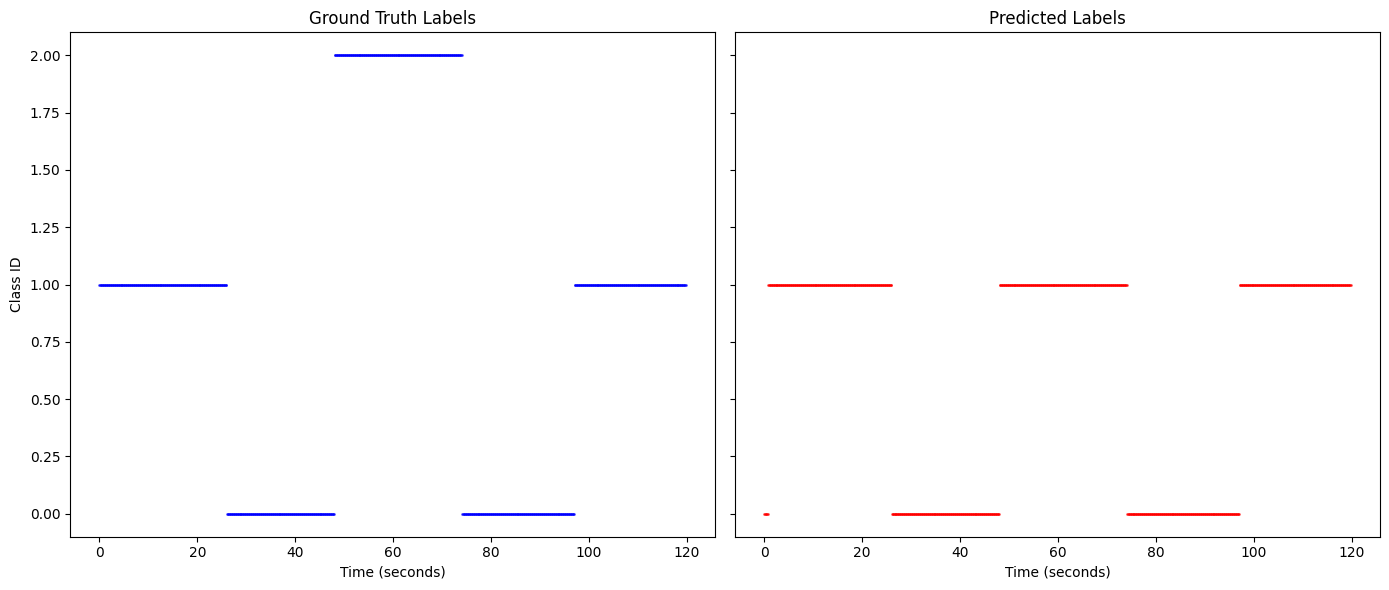

Clustering time series 4 - melspec features
Accuracy: 0.6328828828828829
Confusion Matrix:
[[222   0  23]
 [  2   0 300]
 [  0   1 340]]


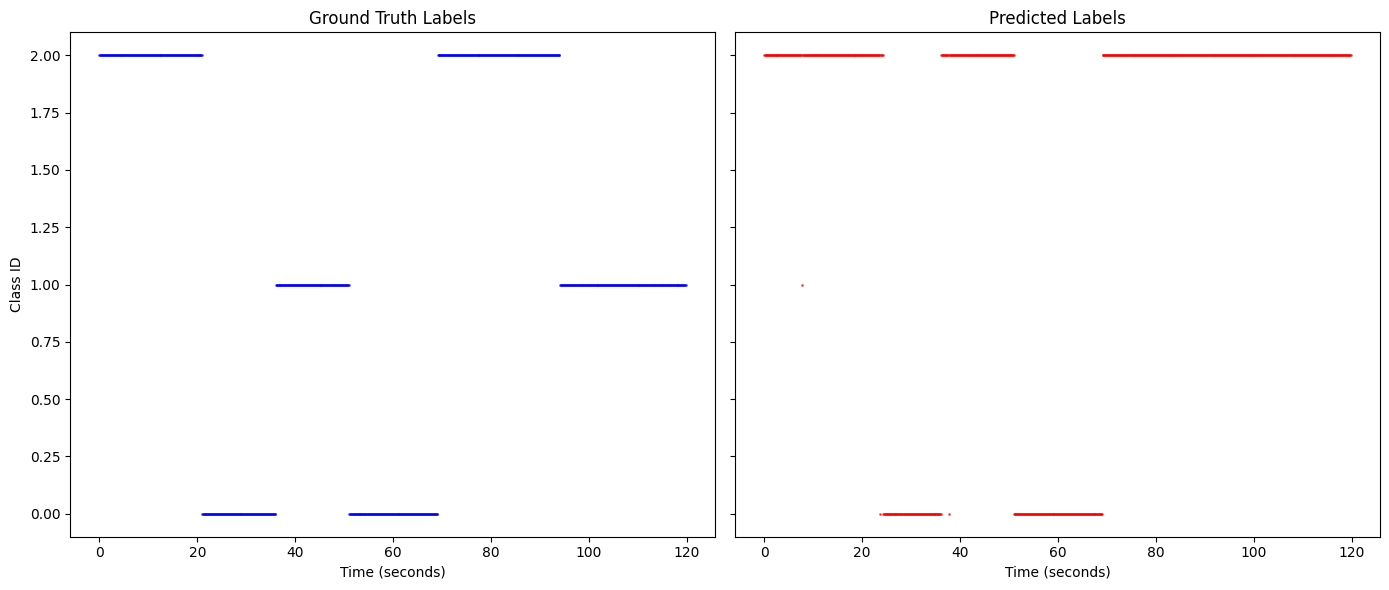

Clustering time series 4 - combined features
Accuracy: 0.8862612612612613
Confusion Matrix:
[[227   0   0]
 [ 84 243  13]
 [  0   0 317]]


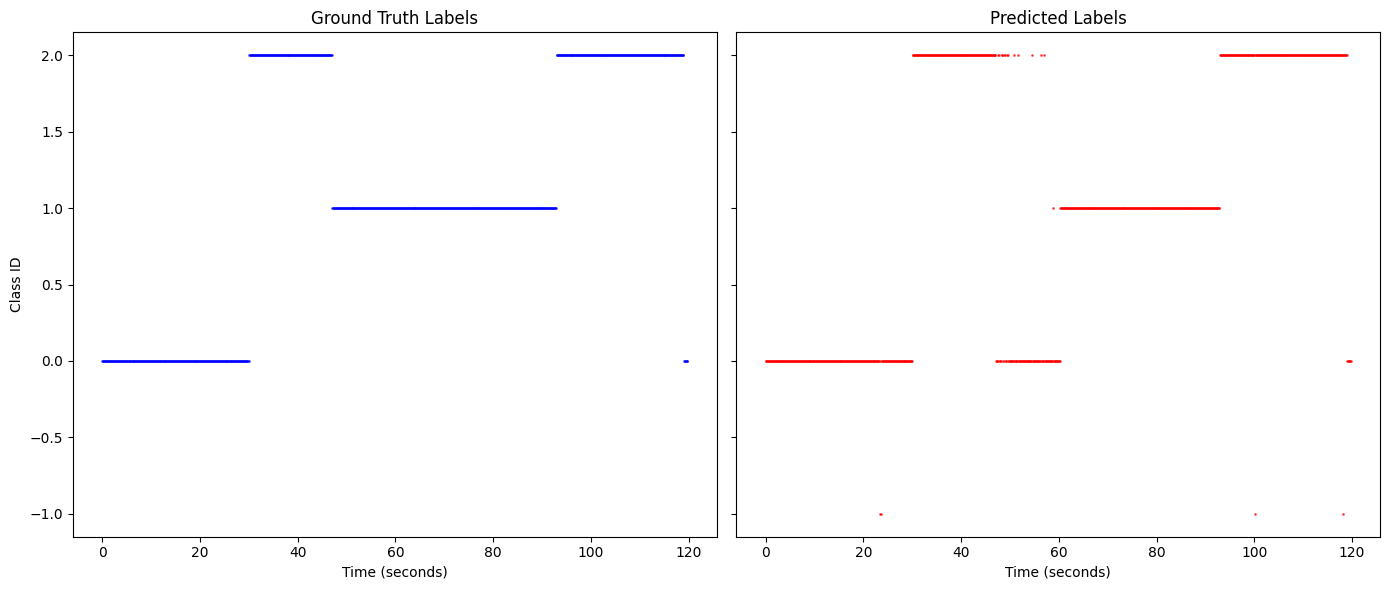

--------------------------------------------------------------------------------


In [18]:
MFCC_PCA_VIGILANCE = 0.15
MELSPEC_PCA_VIGILANCE = 0.26
COMBINED_PCA_VIGILANCE = 0.2

for i in range(5):
    cluster_dataset(i, 'mfccs', mfccs_pca.projected_data.shape[1], 'PCA MFCCs Only Ground Truth vs Predicted Labels', MFCC_PCA_VIGILANCE, True)
    cluster_dataset(i, 'melspec', mfsc_pca.projected_data.shape[1], 'PCA MFSCs Only Ground Truth vs Predicted Labels', MELSPEC_PCA_VIGILANCE, True)
    cluster_dataset(i, 'combined', combined_pca.projected_data.shape[1], 'PCA Combined Ground Truth vs Predicted Labels', COMBINED_PCA_VIGILANCE, True)
    print('-'*80)